# Part 4. DEAP Dataset + Connectivity + SVM

In this part 4, we will focus on feature engineering using connectivity analysis.  Connectivity analysis here refers to the analysis of correlations between different electrodes.

Connectivity analysis is a very useful technique to understand the dynamics of the brain, especially on a very long-duration task.

In this part, we shall extract these connectivities as features.  Then let's try input these features into SVM and see if these features are useful for predicting the four valence-arousal classes that we have obtained from Part 1.

Welcome back to part 4 of this zero-to-hero EEG analysis.

Previously, we learnt that basic Spectral Information (FFT,PSD) can somehow capture the emotion (70% using 5 bands of each electrodes).
However, when we considered the asymetry between 2-electrodes, the accuracy increase to 75%. (We have not yet find the way to mearge the 5 different information)

In brain science, there is a theory that neurons work together. One neuron activate another and so on. This chain (or could be parallel) of activation is in this topic "Connectivity".

This topic is much deeper and harder to simplify (one reason is because it is an on going research) and this tutorial has no intension to explain connectivity theory to you. Therefore, a self-research is a must.

There are multiple ways (a lot of waysss) to measure connectivity. One way is to look at phase.

If the two brain region are working together, their rythm are somewhat synchronize.

OK good, we just match the two electrodes and find the correlation. if it is high then there is connectivity.

Well, that is the basis. In reality, EEG data is highly correlated because each electrode share the same data (an activation is recorded by multiple electrodes). 

One way to counter this is to apply [`surface laplacian`](https://www.youtube.com/watch?v=CodQ5-pmXdQ) method. It is not a perfect method but rather a standard technique. Look into the literature for more detail.

Let's us apply this `surface laplacian` first.

## 1. Loading dataset

Let's first reuse the dataset loader we have created in Part 1.

In [1]:
import numpy as np
import pickle

# this time I will load the Dataset class from `./components/dataset.py`
from components.dataset import Dataset
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset
dataset = Dataset(path, "Valence")

data  = np.array(dataset[:]['data'])
label = np.array(dataset[:]['label']).squeeze()

print("Data shape: " , data.shape)  #15360 = 32 * 40 trials * 12 segments, 32 EEG channels, 672 samples
print("Label shape: ", label.shape)  #two classes of valence

Data shape:  (15360, 32, 672)
Label shape:  (15360,)


Here I only cache the data from the loader.

Loading from cache is faster in my machine.

In [3]:
# Here I can load the data from cache (work a bit faster than loop through the /data/*.dat)
def save(data,filename):
    with open(f'cache/{filename}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    with open(f'cache/{filename}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    return data

# save(data, 'data_valence')
# save(label, 'label_valence')

data = load('data_valence')
label = load('label_valence')

print("Data shape: " , data.shape)  #15360 = 32 * 40 trials * 12 segments, 32 EEG channels, 672 samples
print("Label shape: ", label.shape)  #two classes of valence

# I won't use this `dataset` object anymore. Save a lot of RAM.
del(dataset)

Data shape:  (15360, 32, 672)
Label shape:  (15360,)


## 2. The correlation part

As said in the begining, EEG data is high correlation.

Let's prove that it is true.

**Note: For instace why it should be true is when you blink, the both electrode Fp1 Fp2 measure your blink.*

The easiest way to prove that data are shared between the electrodes is finding correlation. (Wow, i said this word multiple time)

The correlation is somewhat weak term. The number we got from the function meanless unless you compare with another thing. (Confuse? Think of the loss term in Deep Learning, It means nothing unless you compare it in series).

In [22]:
# Here is I calculate correlation step by step

sample = data[0]
# (32, 672)
# sample.shape

# This will has correlation matrix at the end
corr_sample = []

# Get eletrode_a from all electrtodes
for index_a in range(32):
    corr_row = []
    scaler = None
    # Compare electrode_a to all electrodes
    for index_b in range(32):
        electrode_a = sample[index_a]
        electrode_b = sample[index_b]
        # https://numpy.org/doc/stable/reference/generated/numpy.correlate.html
        coeff = np.correlate(electrode_b, electrode_a, mode='valid')
        corr_row.append(coeff)
        if(index_a == index_b): scaler = coeff

    corr_row = np.hstack(corr_row)
    corr_row = corr_row / scaler
    # print(corr_row.shape) => (32,)
    corr_sample.append(corr_row)

corr_sample = np.vstack(corr_sample)
# print(corr_sample.shape) => (32,32)


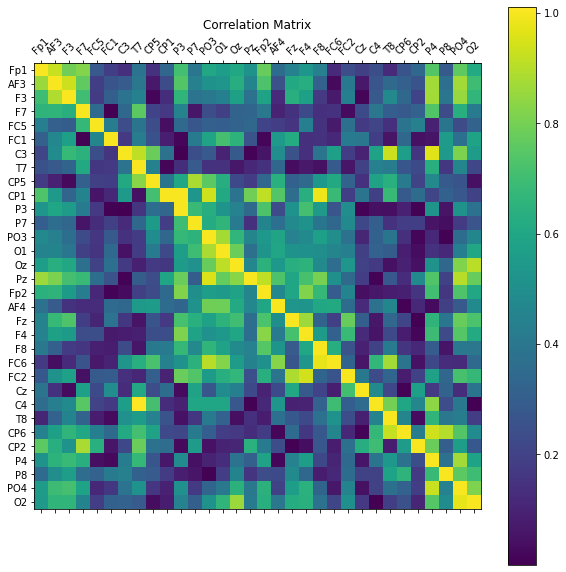

In [23]:
import matplotlib.pyplot as plt

ch_names = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
f = plt.figure(figsize=(10, 10))
plt.matshow(abs(corr_sample), fignum=f.number)
plt.xticks(range(len(ch_names)), ch_names, rotation=45)
plt.yticks(range(len(ch_names)), ch_names)
cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix');

The lighter the colour, the greater information they share.

Let's say the Fp1-Fp1 is the maximun information shared = 1. 

Let's see the correation of Fp1 compares another

In [38]:
corr_Fp1 = abs(corr_sample[ch_names.index('Fp1')])

for orderd_index in corr_Fp1.argsort()[::-1]:
    print( corr_Fp1[orderd_index], ch_names[orderd_index]  )

1.0 Fp1
0.9260536 AF3
0.821613 F7
0.7900972 F3
0.77451545 Fp2
0.7598759 PO4
0.74120134 P4
0.70947576 P3
0.61753434 O2
0.6059011 Oz
0.6053959 PO3
0.5621436 O1
0.5293826 F4
0.52142894 Pz
0.44434643 Fz
0.43891737 F8
0.39555243 P7
0.383458 T7
0.3575377 AF4
0.33959383 CP2
0.33204433 CP1
0.2851352 P8
0.28436184 FC5
0.26125258 CP6
0.24175304 C4
0.23949584 FC2
0.1922385 Cz
0.18832019 FC1
0.14312485 CP5
0.13717708 C3
0.12257443 T8
0.120949775 FC6


<img src="https://upload.wikimedia.org/wikipedia/commons/6/6e/International_10-20_system_for_EEG-MCN.svg">

Wow. Fp1 and AF3 near recored the same data. It could be the same data if we delayed the electrode_b a bit. But that is question for later.

For now, let's `Surface Laplacian` the data

In `mne`, the function to use is [Current Source Density (CSD)](https://mne.tools/stable/auto_examples/preprocessing/eeg_csd.html?highlight=spatial%20laplacian)

In [44]:
from mne.preprocessing import compute_current_source_density
import mne

# convert data to mne.Epochs
ch_names = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
ch_types = ['eeg'] * len(ch_names)
sfreq = 128 #Hz
# https://mne.tools/stable/generated/mne.create_info.html
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
epochs = mne.EpochsArray(data,info)
epochs.set_montage('standard_1020')

# I ran out of RAM
del(data)

epochs_csd = compute_current_source_density(epochs)


Not setting metadata
Not setting metadata
15360 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Fitted sphere radius:         91.4 mm
Origin head coordinates:      1.0 7.3 50.2 mm
Origin device coordinates:    1.0 7.3 50.2 mm


Let's calculate the correlation again with the CSD data

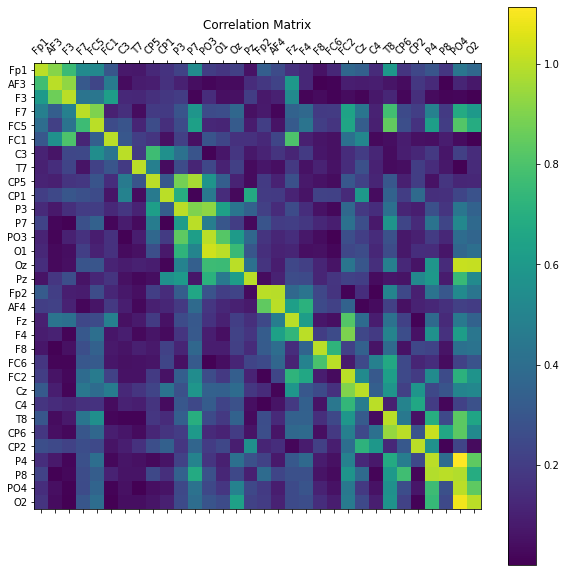

1.0 Fp1
0.9091728367128609 AF3
0.759389404410194 F3
0.5920178061499116 T8
0.5392559727857197 P7
0.5340613955410654 F7
0.5202827941467469 FC5
0.4381353671390498 PO4
0.37820239594916777 O2
0.3728413570877575 FC2
0.34352491605241786 Cz
0.3348395515024905 Fp2
0.2973826567287101 FC1
0.2961737053766444 P4
0.2559005792097564 AF4
0.23574479637355325 CP2
0.21808215111786977 P3
0.21134380579660028 Oz
0.20432248335468034 PO3
0.17871407132280245 O1
0.17723312125906884 P8
0.17168185490339752 CP6
0.16172971870536865 CP1
0.15843781157276257 Fz
0.135495142486162 C4
0.12986920561806914 CP5
0.12646195641373978 FC6
0.12512982219997862 F4
0.07799588594363188 C3
0.07054608369808789 T7
0.054904802951614776 F8
0.05472577976724237 Pz


In [55]:
# Here is I calculate correlation step by step

sample = epochs_csd._data[0]
# (32, 672)
# sample.shape

# This will has correlation matrix at the end
corr_sample = []

# Get eletrode_a from all electrtodes
for index_a in range(32):
    corr_row = []
    scaler = None
    # Compare electrode_a to all electrodes
    for index_b in range(32):
        electrode_a = sample[index_a]
        electrode_b = sample[index_b]
        # https://numpy.org/doc/stable/reference/generated/numpy.correlate.html
        coeff = np.correlate(electrode_b, electrode_a, mode='valid')
        corr_row.append(coeff)
        if(index_a == index_b): scaler = coeff

    corr_row = np.hstack(corr_row)
    corr_row = corr_row / scaler
    # print(corr_row.shape) => (32,)
    corr_sample.append(corr_row)

corr_sample = np.vstack(corr_sample)
# print(corr_sample.shape) => (32,32)

f = plt.figure(figsize=(10, 10))
plt.matshow(abs(corr_sample), fignum=f.number)
plt.xticks(range(len(ch_names)), ch_names, rotation=45)
plt.yticks(range(len(ch_names)), ch_names)
cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix');
plt.show()

corr_Fp1 = abs(corr_sample[ch_names.index('Fp1')])
for orderd_index in corr_Fp1.argsort()[::-1]:
    print( corr_Fp1[orderd_index], ch_names[orderd_index]  )


In [61]:
print('Non CSD sum of correlation coeff:', sum([1.0, 0.9260536, 0.821613, 0.7900972, 0.77451545, 0.7598759, 0.74120134, 0.70947576, 0.61753434, 0.6059011, 0.6053959, 0.5621436, 0.5293826, 0.52142894, 0.44434643, 0.43891737, 0.39555243, 0.383458, 0.3575377, 0.33959383, 0.33204433, 0.2851352, 0.28436184, 0.26125258, 0.24175304, 0.23949584, 0.1922385, 0.18832019, 0.14312485, 0.13717708, 0.12257443, 0.120949775]))

print('CSD sum of correlation coeff:', sum([1.0,0.9091728367128609 ,0.759389404410194 ,0.5920178061499116 ,0.5392559727857197 ,0.5340613955410654 ,0.5202827941467469 ,0.4381353671390498 ,0.37820239594916777 ,0.3728413570877575 ,0.34352491605241786 ,0.3348395515024905 ,0.2973826567287101 ,0.2961737053766444 ,0.2559005792097564 ,0.23574479637355325 ,0.21808215111786977 ,0.21134380579660028 ,0.20432248335468034 ,0.17871407132280245 ,0.17723312125906884 ,0.17168185490339752 ,0.16172971870536865 ,0.15843781157276257 ,0.135495142486162 ,0.12986920561806914 ,0.12646195641373978 ,0.12512982219997862 ,0.07799588594363188 ,0.07054608369808789 ,0.054904802951614776 ,0.05472577976724237]))

Non CSD sum of correlation coeff: 14.872452145000002
CSD sum of correlation coeff: 10.063599232277127


Base on my lazy summation (because I forget the sum them and I don't want to rerun the tutorial), the CSD data has lower the correlation as expected.

Finally, we can do this connectivity thing.

In [63]:
save(epochs_csd, 'epochs_csd_valence')

## 3. Connectivity Analysis

*You can start run from here*

[Emotional EEG Classification using Connectivity Features and Convolutional Neural Networks](https://arxiv.org/pdf/2101.07069.pdf)

Before we jump right into the `connectivity`, let's up think what make sense here.

There are various ways to calculate the connectivity. As shown above, the correlation between electrodes is one of the way.

I will call this `connectivity within trial` and the correlation has the names `Pearson correlation coefficient` ($R^2$).

You could also find the connectivity between different trials which makes sense in the ERP (Event-Related Potential).

Since we are working with Emotion and 5 frequency bands delta (0-4), theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz), and gamma (30 - 64 Hz) is what we are interested (is what I am interested, not nesseary you), we want to do `within trial` and use the result as features for SVM later in the tutorial.

Sure you can see this task as ERP task if you calculate a baseline trial. However, it is not very common to do so.

Let's try the `Pearson correlation coefficient` ($R^2$) using `within trial`

Previously, I did a very simple Correlation matrix using `numpy.correlate` function. Now, it is time to look at the actual equation.

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

$$ C = \frac{Cov[X,Y]}{\sigma_{x}  \sigma_{y}} $$

In this `Pearson correlation coefficient`, we do not look at each freqncy band seperately but rather look at how each brain region interact with each other. For instance, if everytime we are happy then region_a and region_b work together. Hence, a high correlation of region a and b on every happy trial.

The correlation feature of 32*32 channels is 1024 features.

Let's code

In [7]:
import numpy as np
import pickle
import mne
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def load(filename):
    with open(f'cache/{filename}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    return data

def save(data,filename):
    with open(f'cache/{filename}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def pearson_correlation(x,y):
    """ x,y denoted the signal_x and signal_y following the equation """
    cov = np.cov(x, y)
    # print(cov)
    # [[ 8806859.74527069  8007149.0906219 ] ==> [[cov_xx, cov_xy]
    # [ 8007149.0906219  10396797.72458848]]      [cov_yx, cov_yy]]
    cov_xy = cov[0,1] # or cov[1,0]
    cov_xx = cov[0,0]
    cov_yy = cov[1,1]
    corr = cov_xy / ( cov_xx**0.5 * cov_yy**0.5  )
    return corr

import time
def train_model(X_ori,y_ori, kernel='rbf'):
    # Make a copy because I am paranoid
    X,y = X_ori.copy(), y_ori.copy()

    from sklearn.svm import SVC
    from sklearn.utils import shuffle
    from sklearn.model_selection import cross_val_score

    X_shuff,y_shuff = shuffle(X,y)
    model = SVC(kernel=kernel,max_iter=10000)
    cross = cross_val_score(model, X_shuff, y_shuff, cv=3)

    model = SVC(kernel=kernel, max_iter=10000)
    model.fit(X_shuff, y_shuff)
    ans = model.predict(X_shuff)
    acc = sum(ans == y_shuff) / len(y_shuff)
    return model, acc, cross

    
epochs_csd = load('epochs_csd_valence')

In [3]:
# This will be me calculate Correlation feature with shape (n_trials/n_epochs, 1024)
X = []
for epoch in tqdm(epochs_csd):
    corr_epoch = []
    for index_a in range(32):
        for index_b in range(32):
            p_corr = pearson_correlation(epoch[index_a], epoch[index_b])
            corr_epoch.append(p_corr)
    corr_epoch = np.hstack(corr_epoch)
    # print(corr_epoch.shape) => (1024,)
    X.append(corr_epoch)

X = np.vstack(X)
print(X.shape) # => (15360, 1024)
save(X, 'X_pearson')

  0%|          | 0/15360 [00:00<?, ?it/s]

(15360, 1024)


Let's SVM its

In [5]:
X = load('X_pearson')
y = load('label_valence')
X.shape, y.shape

((15360, 1024), (15360,))

In [6]:
start = time.time()
model, acc, cross = train_model(X, y, kernel='rbf')
# We can save the model and reuse it later
print(f"\tAcc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

	Acc=0.67552 | 3-CV score=0.65885 STD=0.00997| Time spend=991.2590882778168


OMG! It took 991 seconds to finish the run. Well, it was 1024 features. However, This result was a lot better than the `all_asymetry` did.

Next, we are going to calculate the `pearson correlation` of a frequncy content between electrodes.

The function we are going to use [`numpy.fft.fft`](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html) to calculate the both FFT and obtain phase information (which we will be using later so we going to learn the function now).

Our previous example find correlation between two pure signals which is not wrong. However, if the two signals are actually correlated but delay, it could result in low correlation coefficient. Instead of trying to phase-lock the signal (which is a must in ERP), we are going to convert the signal from Time domain into Freq domain using FFT instead. (Actually, the PSD function is useable since it is in Freq domain too).

In [71]:
def calculate_fft(signal, sfreq):
    """ signal: can be 1D array of (n_sample,) or 2D array of (n_signal, n_sample)  """
    number_sample = signal.shape[-1]

    # the result will be a complex number. We can obtain the magnitude using `absolute`
    magnitude = np.abs(np.fft.fft(signal))
    # scale the result
    magnitude = magnitude / (number_sample/2)
    # Selecting the range
    magnitude = magnitude.T[:number_sample//2].T
    freq_range = np.fft.fftfreq(number_sample, d=1/sfreq)[:number_sample//2]

    return magnitude, freq_range

X = []
for epoch in tqdm(epochs_csd):
    corr_mag = []
    # (32, 336) (336,)
    mag, f_range = calculate_fft(epoch, 128)
    for index_a in range(32):
        for index_b in range(32):
            p_corr = pearson_correlation(mag[index_a], mag[index_b])
            corr_mag.append(p_corr)
    corr_mag = np.hstack(corr_mag)
    # print(corr_mag.shape)# => (1024,)
    X.append(corr_mag)
    # break

X = np.vstack(X)
print(X.shape) # => (15360, 1024)
save(X, 'X_fft_pearson')

  0%|          | 0/15360 [00:00<?, ?it/s]

(15360, 1024)


In [72]:
X = load('X_fft_pearson')
y = load('label_valence')
print(X.shape, y.shape)

start = time.time()
model, acc, cross = train_model(X, y, kernel='rbf')
# We can save the model and reuse it later
print(f"\tAcc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

(15360, 1024) (15360,)
	Acc=0.72311 | 3-CV score=0.69538 STD=0.00106| Time spend=617.6518638134003


This time, we bump up the accuray to 72% with nearly 70% of CV score. Sweet!

Next, we are going to explore the connectivity base on Phase of the signal.

In the previous two examples, we kind of ignore the phase. To consider Phase, there are way to measure the connectivity through Phase.

- [Phase Lag Index (PLI)](https://www.youtube.com/watch?v=jdY-qHz6Zo8)

$$ PLI(j,k) = | n^{-1} \Sigma^{n}_{t=1} sign(Im[e^{i (\phi^j - \phi^k) t}])  | $$

- [Inter-site phase clustering (ISPC)](https://www.youtube.com/watch?v=4vwj7t6yDQk)

$$ ISPC(j,k) = | n^{-1} \Sigma^{n}_{t=1} e^{i ( \phi^j - \phi^k)t } |$$

- [phase locking value (PLV)](https://arxiv.org/pdf/2101.07069.pdf)

$$ PLV(i,k) = \frac{1}{T} | \Sigma^{T}_{t=1} exp(j(\phi^{t}_{i} - \phi^{t}_{k}))  | $$

- [Phase-Coherence](https://github.com/emma-holmes/Phase-Coherence-for-Python) : Note that the same method is sometimes referred to as the phase locking value (PLV)--although some implementations of the PLV use a time-series filter rather than conducting the analyses in the frequency domain, as used here.

Well, ISPD and PLV look to be the same euqation (this two names same function happen a lot).

To calculate the phase, we have to select which frequncy you want to obtain the phase. In our case, there will be 64 phases (128/2) per electrode. Later, according to the equation, it will sum down to *one* number.

Let's code the PLV/ISPC

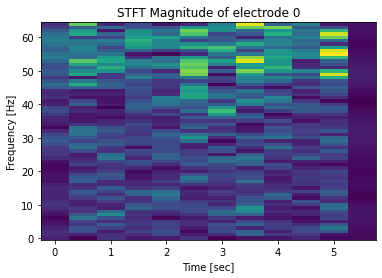

(array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [0.33333333, 0.79281859, 0.85814091, ..., 0.80216808, 0.85295706,
         0.83333333],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        ...,
        [1.        , 0.99283242, 0.9981587 , ..., 0.99902754, 0.99798618,
         1.        ],
        [1.        , 0.98987042, 0.99307326, ..., 0.99820315, 0.99657745,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ]]),
 (528, 65))

In [11]:
def calculate_stft(signals, sfreq):
    from scipy import signal
    # This is short time fourier transform. Sound fancy but it actually is a FFT with smaller window size.
    # In this case we use the window size = sampling rate.
    # Our signal contain 672 samples, thus, a window size of 128 wil result in 5.25 = > 6 time frames.
    # Moreover, we all so have overlapping of half window size. Therefore, 6 + 6 = 12 time frames
    f_range, t_range, Z = signal.stft(signals, sfreq, nperseg=sfreq, nfft=sfreq)
    magnitude = np.abs(Z) 
    # magnitude.shape => (32, 65, 12)

    phase = np.angle(Z)
    # phase.shape => (32, 65, 12)

    return magnitude, phase, f_range, t_range

def PLV_stft(phase):
    plv = []
    # (32, 65, 12) => (channels, freqs, times)
    # print(phase.shape)
    for index_a in range(phase.shape[0]):
        for index_b in range(index_a+1):
            # shape = (65,12)
            phase_a, phase_b = phase[index_a], phase[index_b]
            phase_diff = phase_a - phase_b
            # sum along the time size
            plv_ab = np.abs(np.average(np.exp(complex(0,1) * phase_diff), axis=1))
            plv.append(plv_ab)
    # shape (528, 65)
    # 528 is number of pairs that is not duplicate
    # 65 is number of phase of frequencies
    plv = np.vstack( plv )
    return plv

mag, phase, f_range, t_range = calculate_stft(epochs_csd.get_data()[500], 128)
plt.pcolormesh(t_range, f_range, mag[0])
plt.title('STFT Magnitude of electrode 0')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
plv = PLV_stft(phase)
plv, plv.shape

In [404]:
X = []
for epoch in tqdm(epochs_csd):
    # (32, 65, 12) (65,)
    _, phase, f_range, _ = calculate_stft(epoch, 128)
    plv = PLV_stft(phase)
    # print(plv.shape)# => (528, 65)
    X.append(plv)

X = np.stack(X)
print(X.shape) # => (15360, 528, 65)
save(X, 'X_PLV_stft')

  0%|          | 0/15360 [00:00<?, ?it/s]

(15360, 528, 65)


In [3]:
X = load('X_PLV_stft')
print(X.shape)
# Sum the information down in frequcny axis from 65 to 5 based on EEG freq band.
# Otherwise, there will be toooooooo many feature.
X_5 = np.concatenate( [ X[:, :,0:4].mean(axis=2),
                        X[:, :,4:8].mean(axis=2),
                        X[:, :,8:12].mean(axis=2),
                        X[:, :,12:30].mean(axis=2),
                        X[:, :,30:64].mean(axis=2),],axis=1 )
print(X_5.shape)
save(X_5, 'X_PLV_stft_5')

(15360, 2640)


In [2]:
X = load('X_PLV_stft_5')
y = load('label_valence')
print(X.shape, y.shape)

start = time.time()
model, acc, cross = train_model(X, y, kernel='rbf')
# We can save the model and reuse it later
print(f"\tAcc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

(15360, 2640) (15360,)
	Acc=0.78073 | 3-CV score=0.7168 STD=0.00564| Time spend=1206.8660593032837


The PLV feature improve our performance to 78% and CV of 72%. The result is pretty satisfying.

Time to calculate the last PLI. Here I copy the equation from above.

$$ PLI(j,k) = | n^{-1} \Sigma^{n}_{t=1} sign(Im[e^{i (\phi^j - \phi^k) t}])  | $$

*Note: Sign is a function that only take the + or -*

In [13]:
def PLI(phase):
    j = complex(0,1)
    pli = []
    for index_a in range(phase.shape[0]):
        for index_b in range(phase.shape[0]):
            phase_diff = phase[index_a] - phase[index_b]
            # print(phase_diff.shape) => (336,)
            pli_ab = np.abs(np.sign(np.imag(np.exp( j * phase_diff  ))).mean())
            
            pli.append(pli_ab)
    pli = np.hstack(pli)
    return pli

def PLI_stft(phase):
    plv = []
    # (32, 65, 12) => (channels, freqs, times)
    # print(phase.shape)
    for index_a in range(phase.shape[0]):
        for index_b in range(index_a+1):
            # shape = (65,12)
            phase_a, phase_b = phase[index_a], phase[index_b]
            phase_diff = phase_a - phase_b
            # sum along the time size
            plv_ab = np.abs(np.average(   np.sign(np.imag(   np.exp(complex(0,1) * phase_diff) ))  , axis=1))
            plv.append(plv_ab)
    # shape (528, 65)
    # 528 is number of pairs that is not duplicate
    # 65 is number of phase of frequencies
    plv = np.vstack( plv )
    return plv



mag, phase, f_range, t_range = calculate_stft(epochs_csd.get_data()[0], 128)
pli = PLI_stft(phase)
pli, pli.shape

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.33333333, 0.        ,
         0.25      ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.16666667, 0.        , 0.        , ..., 0.16666667, 0.        ,
         0.08333333],
        [0.16666667, 0.16666667, 0.16666667, ..., 0.        , 0.66666667,
         0.08333333],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 (528, 65))

In [19]:
X = []
# count = 0
for epoch in tqdm(epochs_csd):
    # (32, 65, 12) (65,)
    _, phase, f_range, _ = calculate_stft(epoch, 128)
    pli = PLI_stft(phase)
    # print(pli.shape)# => (528, 65)
    X.append(pli)
    # count += 1
    # if count == 5:    break

X = np.stack(X)
print(X.shape) # => (15360, 528, 65)
save(X, 'X_PLI_stft')

  0%|          | 0/15360 [00:00<?, ?it/s]

(15360, 528, 65)


In [20]:
X = load('X_PLI_stft')
print(X.shape)
# Sum the information down in frequcny axis from 65 to 5 based on EEG freq band.
# Otherwise, there will be toooooooo many feature.
X_5 = np.concatenate( [ X[:, :,0:4].mean(axis=2),
                        X[:, :,4:8].mean(axis=2),
                        X[:, :,8:12].mean(axis=2),
                        X[:, :,12:30].mean(axis=2),
                        X[:, :,30:64].mean(axis=2),],axis=1 )
print(X_5.shape)
save(X_5, 'X_PLI_stft_5')

(15360, 528, 65)
(15360, 2640)


In [21]:
X = load('X_PLI_stft_5')
y = load('label_valence')
print(X.shape, y.shape)

start = time.time()
model, acc, cross = train_model(X, y, kernel='rbf')
# We can save the model and reuse it later
print(f"\tAcc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

(15360, 2640) (15360,)


/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	Acc=0.85456 | 3-CV score=0.56361 STD=0.00432| Time spend=1569.2779262065887


We got something different here. The accury jump to 85% but CV score is drop to 56%.

Well, it does look like the data is overfit during training or the data is not generalized.

Finally, we will look into the [`transfer entropy (TE)`](https://arxiv.org/pdf/2101.07069.pdf)

$$ TE(i \rightarrow k) = \frac{1}{T-1} \Sigma^{T-1}_{t=1} p( x^t_i,x^t_k,x^{t+1}_k ) log \frac{ p( x^{t+1}_{k} | x^{t}_{i}, x^{t}_{k} ) }{ p( x^{t+1}_{k} | x^{t}_{k} ) }  $$

Luckily, this time we have library to you. Hooray~!

https://elife-asu.github.io/PyInform/starting.html

However, I try to run on my poor laptop and it could not even start the first comparision. Look like this technique is memory hungry

## 4. MNE_Connectivity

*you can start run from here*

We are finally reach to the end of this tutorial. I don't want to create another file so I will just keep going.

Just like `MNE_feature`, the folk at `MNE` also create a library called `MNE_connectivity` for calculate connectivity stuff.

However, the library only focus on CSD+PSD calculation (It will perform CSD and then PSD and then connectivity).

In the library, there is two main function

1. [mne_connectivity.spectral_connectivity_epochs](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_epochs.html)

  - A epoch-wise connecticity.

2. [mne_connectivity.spectral_connectivity_time](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_time.html)

  - A trial-wise connectivity. (within trial)

*P.S. dont quote me on `epoch-wise` or `trial-wise`. I named it myself.*

The main function to read is `1. spectral_connectivity_epochs`. All information is documented there. Then, we can apply the knowledge to `2. spectral_connectivity_time`

When we are calling `spectral_connectivity_epochs`, we have to specify `method` which is *which connectivity you want to calculate*.

Here are the list of `method`.

1. `coh` : Coherence given by:
```
         | E[Sxy] |
C = ---------------------
    sqrt(E[Sxx] * E[Syy])
```

2. `cohy` : Coherency given by:
```
           E[Sxy]
C = ---------------------
    sqrt(E[Sxx] * E[Syy])
```

3. `imcoh` : Imaginary coherence 1 given by:
```
          Im(E[Sxy])
C = ----------------------
    sqrt(E[Sxx] * E[Syy])
```

4. `plv` : Phase-Locking Value (PLV) 2 given by:
```
PLV = |E[Sxy/|Sxy|]|
```

5. `ciplv` : corrected imaginary PLV (icPLV) 3 given by:
```
                 |E[Im(Sxy/|Sxy|)]|
ciPLV = ------------------------------------
         sqrt(1 - |E[real(Sxy/|Sxy|)]| ** 2)
```

6. `ppc` : Pairwise Phase Consistency (PPC), an unbiased estimator of squared PLV 4.

7. `pli` : Phase Lag Index (PLI) 5 given by:
```
PLI = |E[sign(Im(Sxy))]|
```

8. `pli2_unbiased` : Unbiased estimator of squared PLI 6.

9. `wpli` : Weighted Phase Lag Index (WPLI) 6 given by:
```
          |E[Im(Sxy)]|
WPLI = ------------------
          E[|Im(Sxy)|]
```

10. `wpli2_debiased` : Debiased estimator of squared WPLI 6.


So, `PLV` and `PLI` is given in the library. But, where is the `pearson correlation`?

Well, if you look closely to the first method `coh` equation. Does it remind you of something?


$$ S_{xx} = \Sigma(x_{i} - \bar{x})^{2} $$

$$ S_{yy} = \Sigma(y_{i} - \bar{y})^{2} $$

$$ S_{xy} = \Sigma(x_{i} - \bar{x})(y_{i} - \bar{y}) $$

Well, it is a variance (xx,yy) and covariance (xy)

The `Coherence` is 

$$ C = \frac{ | E[S_{xy}] | }{ \sqrt{E[S_{ss}] * E[S_{yy}]} }  $$

Here is the `pearson correlation` equation

$$ C = \frac{Cov[X,Y]}{\sigma_{x}  \sigma_{y}} $$

The term $E[.]$ is expected value. This use in the Random Variable when $X$ is a random process. $E[X]$ is $\bar{X}$.

Therefore if we try to merge the two world (Random Variable and Discrete Distribution), we can see that the `Coherence` is actually is the `Correlation` we love (with `abs` as a twist).

If you want an exactly `pearson correlation` then `mne_connectivity` has `cohy` method

```
           E[Sxy]
C = ---------------------
    sqrt(E[Sxx] * E[Syy])
```


Note:
- Variability [youtube](https://www.youtube.com/watch?v=d-yK_I0pVFY)
- Random Variable [pdf](https://www0.gsb.columbia.edu/faculty/pglasserman/B6014/RandomVariables.pdf)

However, that is the list of method in `spectral_connectivity_epochs` not `spectral_connectivity_time`.

The list of method in `spectral_connectivity_time` is limited to the following.

- `coh` : Coherence
- `plv` : Phase-Locking Value (PLV)
- `sxy` : Cross-spectrum

Let's try or of them.

In [1]:
import numpy as np
import pickle
import mne
from tqdm.notebook import tqdm

def save(data,filename):
    with open(f'cache/{filename}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    with open(f'cache/{filename}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    return data

# save(data, 'data_valence')
# save(label, 'label_valence')

data = load('data_valence')
label = load('label_valence')

# convert data to mne.Epochs
ch_names = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
ch_types = ['eeg'] * len(ch_names)
sfreq = 128 #Hz
# https://mne.tools/stable/generated/mne.create_info.html
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
epochs = mne.EpochsArray(data,info)
epochs.set_montage('standard_1020')

# I use `epochs` because the mne_connectivity will do CSD for me. I think

Not setting metadata
15360 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


Number of events,15360
Events,1: 15360
Time range,0.000 – 5.242 sec
Baseline,off


In [2]:
from mne_connectivity import spectral_connectivity_time
import matplotlib.pyplot as plt

print(epochs[:10]._data.shape)
con = spectral_connectivity_time(epochs[:10], freqs=[4,5,6,7], mode='multitaper', method='coh')

print(type(con), con.shape, con.get_data('dense').shape)

(10, 32, 672)
Connectivity computation...


/tmp/ipykernel_27838/3979398820.py:5: RuntimeWarning: There were no Annotations stored in <EpochsArray |  10 events (all good), 0 - 5.24219 sec, baseline off, ~1.7 MB, data loaded,
 '1': 10>, so metadata was not modified.
  con = spectral_connectivity_time(epochs[:10], freqs=[4,5,6,7], mode='multitaper', method='coh')


  0%|          |  : 0/528 [00:00<?,       ?it/s]

<class 'mne_connectivity.base.EpochSpectroTemporalConnectivity'> (10, 528, 4, 672) (10, 32, 32, 4, 672)


The function return `mne_connectivity.base.EpochSpectroTemporalConnectivity` class and the shape is (10,528,4,672)

Obviously, the first dimension is `n_epochs`. the third is each freqs `[4,5,6,7]`

But 528, and 672??

If we compare the every 32 electrodes with 32 electrodes, the number of combination is 32 x 32 = 1024. Which is always the feautre set. However, Fp1-Fp2 and Fp2-Fp1 is the same data. When we eliminate the duplicate information we got 528. (calculation can be done)

However, if you are more comfortable with 32 x 32 shape, you can use `con.get_data('dense')`

Now, what is `672`? The `672` is `n_times` which is equal to the `n_sample` of your signal.

So, what we get is connectivity with a shape of `(n_epochs, n_con, n_freqs, n_times)`.

To follow the previous calculation, i will average on the last two axis (`n_freqs`,`n_times`) and flattern them out.

At the end, we will get the array of shape `(n_epochs, n_con)` which is SVM ready.

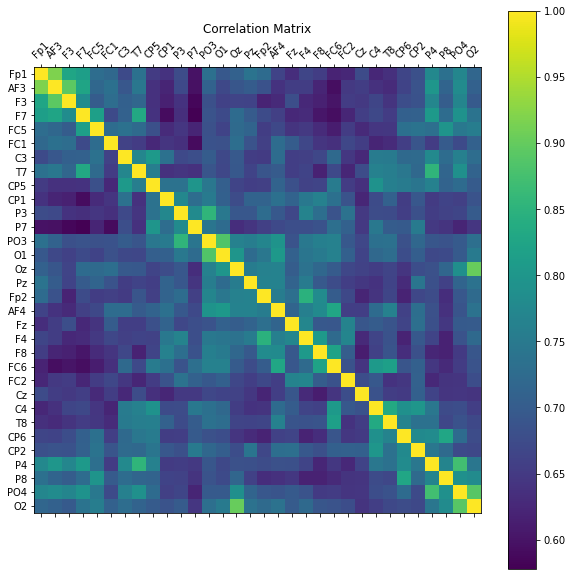

In [75]:
# a plot for fun
f = plt.figure(figsize=(10, 10))

# sum the last two axes
plot_data = con.get_data('dense').mean(axis=3).mean(axis=3)
# print(plot_data.shape) => (10, 32, 32)

plt.matshow(plot_data[0], fignum=f.number)
plt.xticks(range(len(con.names)), con.names, rotation=45)
plt.yticks(range(len(con.names)), con.names)
cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix');

In [76]:
con = spectral_connectivity_time(epochs, freqs=range(64), mode='multitaper')

print(type(con), con.shape, con.get_data('dense').shape)

/tmp/ipykernel_19184/2153218768.py:1: RuntimeWarning: There were no Annotations stored in <EpochsArray |  15360 events (all good), 0 - 5.24219 sec, baseline off, ~2.46 GB, data loaded,
 '1': 15360>, so metadata was not modified.
  con = spectral_connectivity_time(epochs, freqs=range(64), mode='multitaper')


MemoryError: Unable to allocate 2.54 TiB for an array with shape (15360, 528, 64, 672) and data type float64

In [ ]:
# I can not calculate the entire epochs at once because of my poor laptop does not have enough memory
# Let's do it in every 5 epochs instead

X = []
count = 0
for loop in tqdm(range(len(epochs)//5)):
    start_index = loop * 5
    stop_index = (loop+1) * 5
    selected_epochs = epochs[start_index:stop_index]
    con = spectral_connectivity_time(selected_epochs, freqs=range(2,128//2), mode='multitaper', method='coh')
    sum_data = con.get_data('raveled').mean(axis=3).mean(axis=2)
    X.append(sum_data)
    count += 1
    # if count == 4: break

X = np.vstack(X)
print(X.shape)
save(X,'X_mnecon_coh')

# I run for 600 minutes and I gave up.
# But this is my way to extract the connectivity.
# If you want other method like PLV, and 'sxv' just change the `method` argument

## Summary

This tutorial is too long and I think I should summarized it.

Connectivity is a theory that neurons are working together and each human reaction will activate a certain group/pattern of neuron activation.

We want to extract those pattern into features.

Here we start from a very basic `signal correlation`, `pearson correlation`, `pearson correlation with frequency content`, and various of `phase` base analysis.

As mentioned before, this tutorial has no intension to provide all the information you need for this topic. Therefore, I have provided the link for you to study yourself.

There are also multiple of other ways to measure the connectivity which we have not yet explore. 

Finally, the result from the classification are listed below.

- CSD + signal_correlation => Acc=0.67552 | 3-CV score=0.65885 STD=0.00997| Time spend=991.2590882778168

- CSD + freq_correlation => Acc=0.72311 | 3-CV score=0.69538 STD=0.00106| Time spend=617.6518638134003

- CSD + PLV_correation => Acc=0.78073 | 3-CV score=0.7168 STD=0.00564| Time spend=1206.8660593032837

- CSD + PLI_correlation => Acc=0.85456 | 3-CV score=0.56361 STD=0.00432| Time spend=1569.2779262065887

- Transfer Entropy => Crash

- all MNE_connectivity => Crash